### Импорт библиотек

In [1]:
import tarfile
import json 
from typing import List
from functools import partial
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import pairwise_distances

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

### Загрузка данных

In [2]:
#Распаковка архива
zipfile = 'hackathon_files_for_participants_ozon.tar.gz'
tar = tarfile.open(zipfile,"r:gz")
tar.extractall()
tar.close()

In [3]:
#Загрузка данных
df_train = pd.read_parquet('hackathon_files_for_participants_ozon/train_data.parquet', engine='pyarrow').reset_index(drop=True)
df_test = pd.read_parquet('hackathon_files_for_participants_ozon/test_data.parquet', engine='pyarrow').reset_index(drop=True)
df_train_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/train_pairs.parquet', engine='pyarrow').reset_index(drop=True)
df_test_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet', engine='pyarrow').reset_index(drop=True)

### EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457063 entries, 0 to 457062
Data columns (total 8 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   variantid                          457063 non-null  int64 
 1   name                               457063 non-null  object
 2   categories                         457063 non-null  object
 3   color_parsed                       378652 non-null  object
 4   pic_embeddings_resnet_v1           303467 non-null  object
 5   main_pic_embeddings_resnet_v1      457063 non-null  object
 6   name_bert_64                       457063 non-null  object
 7   characteristic_attributes_mapping  457036 non-null  object
dtypes: int64(1), object(7)
memory usage: 27.9+ MB


In [5]:
df_train.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


Представлены следующие данные (8 столбцов и 457063 строк):
* variantid - id товара
* name - наименование товара
* categories - категория товара
* color_parsed - цвет
* pic_embeddings_resnet_v1 - эмбендинги дополнительных изображений
* main_pic_embeddings_resnet_v1 - эмбендинги главного изображения
* name_bert_64 - текстовые эмбендинги (наименование товара)
* characteristic_attributes_mapping - атрибуты

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35730 entries, 0 to 35729
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   variantid                          35730 non-null  int64 
 1   name                               35730 non-null  object
 2   categories                         35730 non-null  object
 3   color_parsed                       26089 non-null  object
 4   pic_embeddings_resnet_v1           19977 non-null  object
 5   main_pic_embeddings_resnet_v1      35730 non-null  object
 6   name_bert_64                       35730 non-null  object
 7   characteristic_attributes_mapping  35726 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.2+ MB


In [7]:
df_test.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51201254,Колодка TDM Electric четырехместная без заземл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],"[[0.34383398, -0.2962618, 0.07987049, -0.08257...","[[0.38310742, -0.7876679, 0.5018278, 0.2090071...","[-0.5060825, 0.5773388, 0.59435517, -0.4958292...","{""Страна-изготовитель"":[""Китай""],""Бренд"":[""TDM..."
1,77151532,Клавиатура черная с черной рамкой для 25-011879,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Запчаст...",[черный],None,"[[0.50964713, 0.7958329, -1.4113188, 0.1999381...","[-0.43467724, 0.6614495, 0.48050267, -0.588880...","{""Страна-изготовитель"":[""Китай""],""Комплектация..."


In [8]:
df_train.categories.describe()

count                                                457063
unique                                                  358
top       {"1": "EPG", "2": "Электроника", "3": "Смартфо...
freq                                                  51300
Name: categories, dtype: object

In [9]:
#Категории по уровням
df_train = df_train.join(pd.json_normalize(df_train.categories.apply(json.loads)))
df_test = df_test.join(pd.json_normalize(df_train.categories.apply(json.loads)))

In [10]:
df_train.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping,1,2,3,4
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о...",EPG,Электроника,"Сетевые фильтры, разветвители и удлинители","Сетевой фильтр, удлинитель, разветвитель"
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс...",EPG,Электроника,Кабели и переходники,Кабель


In [11]:
df_train.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )
df_test.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )

In [12]:
df_train[['categories','cat1','cat2','cat3','cat4']].describe()

,categories,cat1,cat2,cat3,cat4
count,457063,457063,457063,457063,457063
unique,358,1,13,127,357
top,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...",EPG,Электроника,"Смартфоны, планшеты, мобильные телефоны",Смартфон
freq,51300,457063,456843,59389,51300


In [13]:
df_test[['categories','cat1','cat2','cat3','cat4']].describe()

,categories,cat1,cat2,cat3,cat4
count,35730,35730,35730,35730,35730
unique,236,1,6,85,249
top,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",EPG,Электроника,"Смартфоны, планшеты, мобильные телефоны",Смартфон
freq,2866,35730,35718,4753,4109


In [14]:
cat_cols = ['cat1','cat2','cat3','cat4']

In [15]:
for cat in cat_cols:
    print(cat,':', len(df_train[cat].unique()))
    print(df_train[cat].value_counts())
    print('\n')

cat1 : 1
EPG    457063
Name: cat1, dtype: int64


cat2 : 13
Электроника               456843
Хобби и творчество            52
Строительство и ремонт        52
Автотовары                    30
Детские товары                26
Канцелярские товары           18
Дом и сад                     18
Спорт и отдых                 12
Бытовая техника                5
Бытовая химия                  3
Галантерея и украшения         2
Товары для взрослых            1
Товары для животных            1
Name: cat2, dtype: int64


cat3 : 127
Смартфоны, планшеты, мобильные телефоны    59389
Компьютер                                  57572
Чехол                                      40775
Расходник для печати                       38878
Кабели и переходники                       26669
                                           ...  
Спортивные чехлы и сумки                       1
Охота и стрельба                               1
Солнечная, ветряная электростанция             1
Сувениры и подарки              

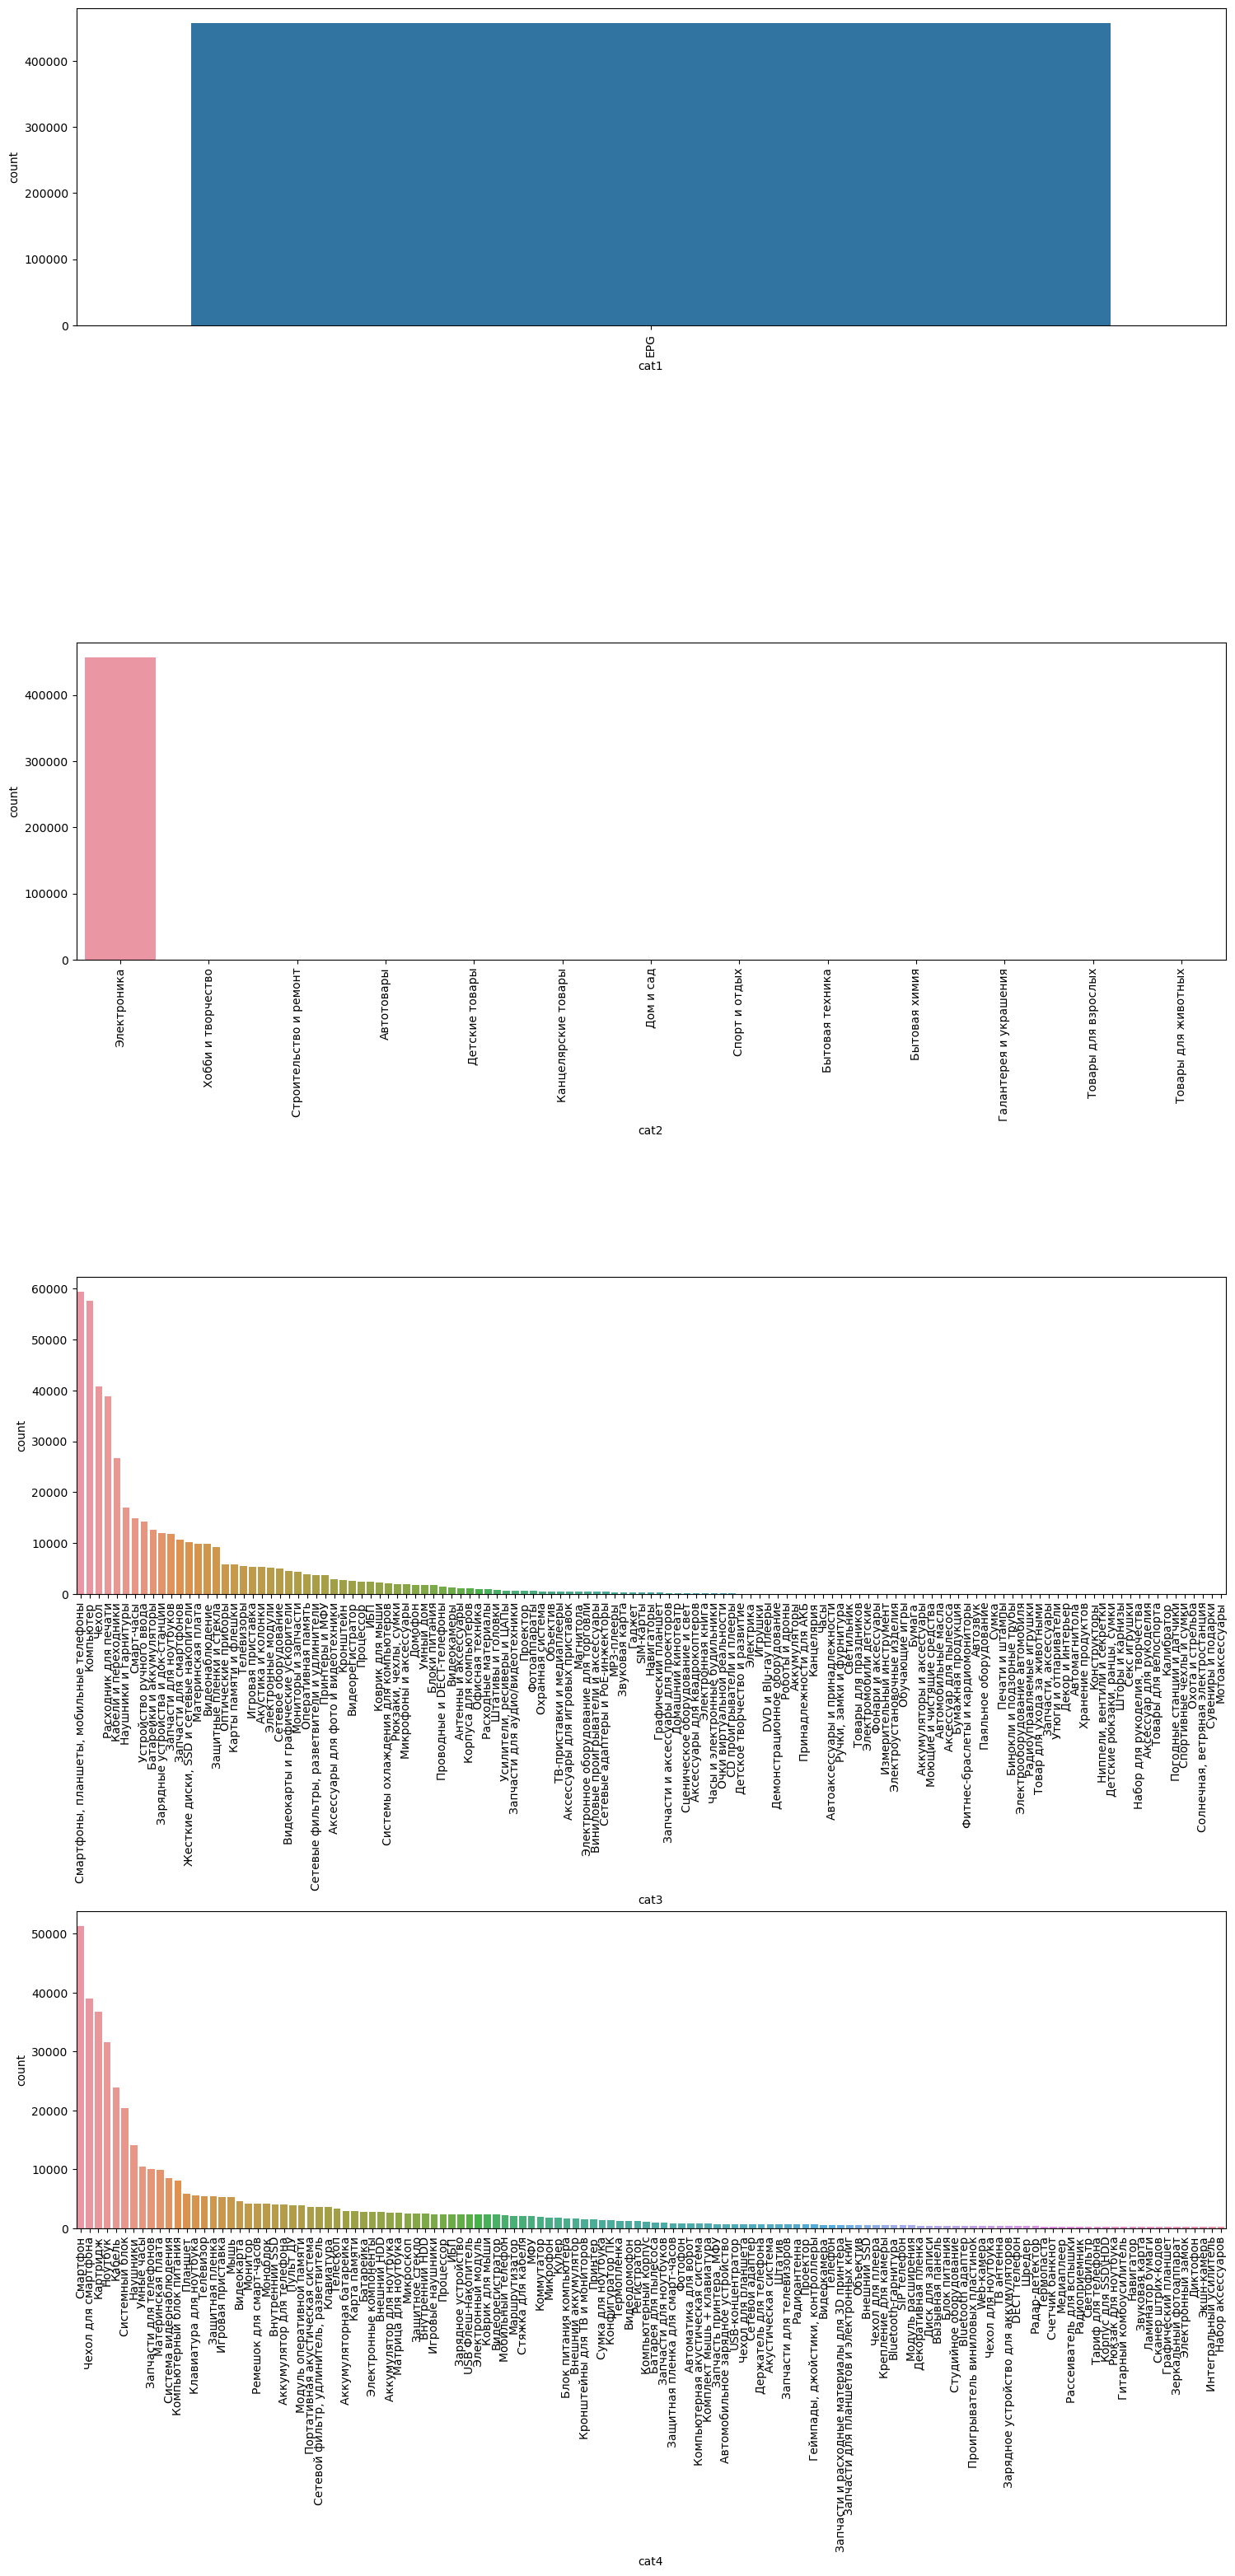

In [16]:
fig, axes = plt.subplots(4, 1, figsize = (18,35))
plt.subplots_adjust(wspace = 0.2, hspace = 1)
axes = axes.flatten()
for i in range(len(cat_cols)):
    cntplt = sns.countplot(x = df_train[cat_cols[i]], data = df_train, order = df_train[cat_cols[i]].value_counts()[:130].index, ax = axes[i])
    plt.setp(cntplt.get_xticklabels(), rotation = 90)

В cat1 только 1 значение, колонку удалим. Колонку categories также удалим, т.к. она дублирует данные.

In [17]:
cat3_counts = df_train.cat3.value_counts().to_dict()
cat3_counts

{'Смартфоны, планшеты, мобильные телефоны': 59389,
 'Компьютер': 57572,
 'Чехол': 40775,
 'Расходник для печати': 38878,
 'Кабели и переходники': 26669,
 'Наушники и гарнитуры': 16944,
 'Смарт-часы': 14811,
 'Устройство ручного ввода': 14235,
 'Батарейки и аккумуляторы': 12548,
 'Зарядные устройства и док-станции': 12014,
 'Запчасти для ноутбуков': 11791,
 'Запчасти для смартфонов': 10716,
 'Жесткие диски, SSD и сетевые накопители': 10221,
 'Материнская плата': 9895,
 'Видеонаблюдение': 9791,
 'Защитные пленки и стекла': 9225,
 'Оптические приборы': 5874,
 'Карты памяти и флешки': 5741,
 'Телевизоры': 5504,
 'Игровая приставка': 5300,
 'Акустика и колонки': 5287,
 'Электронные модули': 5144,
 'Сетевое оборудование': 5026,
 'Видеокарты и графические ускорители': 4578,
 'Мониторы и запчасти': 4361,
 'Оперативная память': 3877,
 'Сетевые фильтры, разветвители и удлинители': 3658,
 'Принтеры и МФУ': 3643,
 'Аксессуары для фото и видеотехники': 2905,
 'Кронштейн': 2650,
 'Видеорегистратор':

In [18]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 500:
        cntr += cat3_counts[cat3]
        
cntr

5929

In [19]:
df_train['cat3_grouped'] = df_train.cat3.apply(lambda x: x if cat3_counts[x] > 500 else 'rest')

In [20]:
#Пропущенные значения
for col in df_train.columns:
    missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(missing*100)))

variantid - 0%
name - 0%
categories - 0%
color_parsed - 17%
pic_embeddings_resnet_v1 - 34%
main_pic_embeddings_resnet_v1 - 0%
name_bert_64 - 0%
characteristic_attributes_mapping - 0%
cat1 - 0%
cat2 - 0%
cat3 - 0%
cat4 - 0%
cat3_grouped - 0%


Есть пропущенные значения в колонках color_parsed (17%) и pic_embeddings_resnet_v1 (34%). Колонку pic_embeddings_resnet_v1 удалим, т.к. пропущено более 30% значения. Колонку color_parsed также удалим, т.к. данная колонка дублирует данные в атрибутах.

In [21]:
df_train_pairs.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


Количество:
 0.0    171527
1.0    135013
Name: target, dtype: int64

Процентное соотношение:
 0.0    55.95583
1.0    44.04417
Name: target, dtype: float64 %


<AxesSubplot:xlabel='target', ylabel='count'>

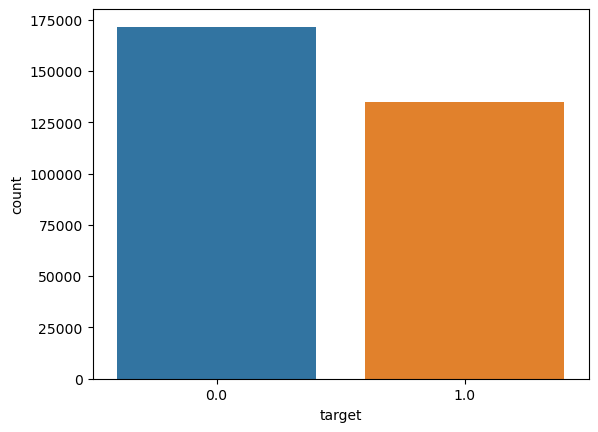

In [22]:
print('Количество:\n', df_train_pairs.target.value_counts()) 
print('\nПроцентное соотношение:\n', df_train_pairs.target.value_counts(normalize=True) * 100, '%')
sns.countplot(x = df_train_pairs.target, data = df_train_pairs, order = df_train_pairs.target.value_counts().index)

44% - дубликаты, 56% - нет